<p>Objetivos: Criar um modelo de Machine Learning que possa prever o empréstimo a ser <strong>aprovado</strong> ou <strong>rejeitado</strong> para um candidato.<p>

Link do problema: https://www.kaggle.com/datasets/bhavikjikadara/loan-status-prediction

<p>Sobre o dataset:<p>
<ul>
  <li><strong>Loan_ID:</strong>ID único do empréstimo.</li>
  <li><strong>Gender:</strong> Se é homem ou mulher.</li>
  <li><strong>Married:</strong>Se é casado(yes) ou não(No).</li>
  <li><strong>Dependents:</strong> Número de pessoas dependentes do cliente.</li>
  <li><strong>Education:</strong> Graduado ou não graduado.</li>
  <li><strong>Self_Employed:</strong> Autônomo (Yes/No).</li>
  <li><strong>ApplicantIncome:</strong> Renda do Candidato.</li>
  <li><strong>CoapplicantIncome:</strong> Renda do Corequerente.</li>
  <li><strong>LoanAmount:</strong> Quantidade do empréstimo em mil.</li>
  <li><strong>Loan_Amount_Term:</strong> Condições do empréstimo em meses.</li>
  <li><strong>Credit_History:</strong> O histórico de crédito atende às diretrizes.</li>
  <li><strong>Property_Area:</strong> Se mora no ambiente urbano, semi-urbano ou rural.</li>
  <li><strong>Loan_Status (Variável alvo):</strong> Empréstimo aprovado (Y/N). </li>
</ul>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly as pt
import plotly.figure_factory as ff
import seaborn as sns
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from yellowbrick.classifier import ConfusionMatrix
from sklearn.metrics import classification_report
from sklearn.tree import plot_tree

# Carregamento dos Dados

In [ ]:
# Carregamento dos dados
loan_status_data = pd.read_csv("/content/loan_data.csv")
loan_status_data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
1,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
2,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
3,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
4,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y


In [ ]:
# informações sobre o dataset
loan_status_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381 entries, 0 to 380
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            381 non-null    object 
 1   Gender             376 non-null    object 
 2   Married            381 non-null    object 
 3   Dependents         373 non-null    object 
 4   Education          381 non-null    object 
 5   Self_Employed      360 non-null    object 
 6   ApplicantIncome    381 non-null    int64  
 7   CoapplicantIncome  381 non-null    float64
 8   LoanAmount         381 non-null    float64
 9   Loan_Amount_Term   370 non-null    float64
 10  Credit_History     351 non-null    float64
 11  Property_Area      381 non-null    object 
 12  Loan_Status        381 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 38.8+ KB


# Análise Exploratória

<p>A base de dados tem 381 registros, se removemos todos os valores NaN sobraria 308 registros, cerca de 80.8399% da base original. Nesse caso será necessário fazer alguns preenchimentos para não perder muitos dados.<p>

In [ ]:
# Quantidade de registros NaN
loan_status_data.isnull().sum()

Loan_ID               0
Gender                5
Married               0
Dependents            8
Education             0
Self_Employed        21
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            0
Loan_Amount_Term     11
Credit_History       30
Property_Area         0
Loan_Status           0
dtype: int64

## Análise individual das características

<p>A variável "Loan_ID" é um identificador do empréstimo, logo não será necessário na construção do modelo de Machine Learning.<p>

### Variável "Gender"

In [ ]:
# Variável Gênero
loan_status_data['Gender'].value_counts()

Male      291
Female     85
Name: Gender, dtype: int64

In [ ]:
# Verificando como o Gênero está relacionado com a variável alvo
pd.crosstab(loan_status_data['Loan_Status'], loan_status_data['Gender'], margins=True)

Gender,Female,Male,All
Loan_Status,,,
N,26,80,106
Y,59,211,270
All,85,291,376


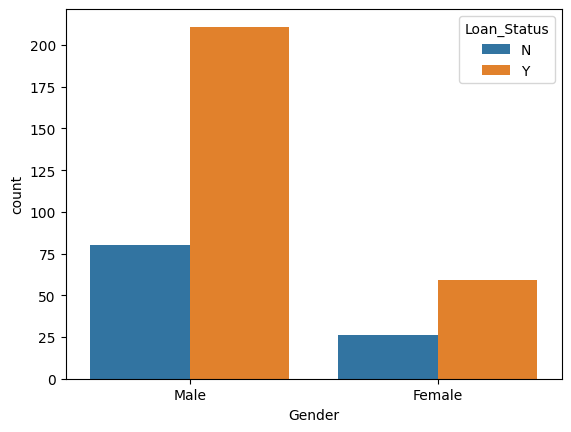

In [ ]:
sns.countplot(x="Gender", hue="Loan_Status", data=loan_status_data);

<p>Vemos que tanto para os homens quanto para as mulheres o empréstimo foi aceito, mas a variável gênero é composta por apenas 22.606% de mulheres e há 5 registros nulos. O NaN será substituido pela classe Female visto que possui poucos registros dessas classes. <p>

### Variável "Married

In [ ]:
# distribuição da Variável Married
loan_status_data['Married'].value_counts()

Yes    228
No     153
Name: Married, dtype: int64

In [ ]:
# Verificando como a condição de casado está relacionado com a variável alvo
pd.crosstab(loan_status_data['Loan_Status'], loan_status_data['Married'], margins=True)

Married,No,Yes,All
Loan_Status,,,
N,52,58,110
Y,101,170,271
All,153,228,381


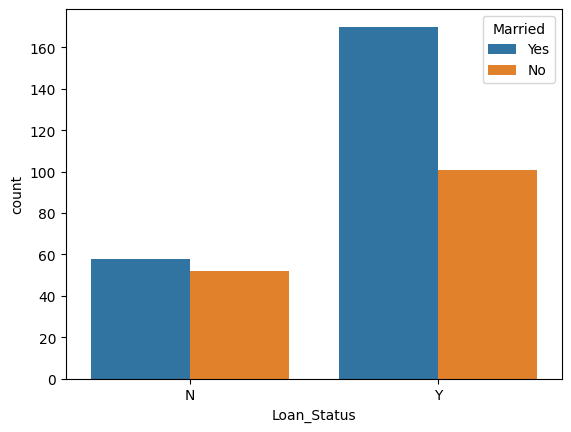

In [ ]:
sns.countplot(x="Loan_Status", hue="Married", data=loan_status_data);

<p>Pelo gráfico vemos que para as pessas que tem o empréstimo negaativo há quase um balanceamento entre casado e não casado, mas há uma quantidade maior de pessoas casadas quando o empréstimo foi aceito e sabemos também que a maioria das pessoas são homens.<p>

### Variável "Dependents"

In [ ]:
# distribuição da Variável Dependents
loan_status_data['Dependents'].value_counts()

0     234
2      59
1      52
3+     28
Name: Dependents, dtype: int64

In [ ]:
# Verificando como a condição de casado está relacionado com a variável alvo
pd.crosstab(loan_status_data['Loan_Status'], loan_status_data['Dependents'], margins=True)

Dependents,0,1,2,3+,All
Loan_Status,,,,,
N,66,17,15,8,106
Y,168,35,44,20,267
All,234,52,59,28,373


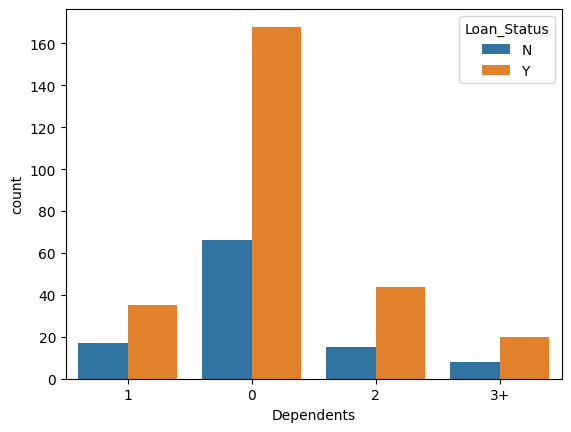

In [ ]:
sns.countplot(x="Dependents", hue="Loan_Status", data=loan_status_data);

<p>Há 8 registros NaN nessa variável e a maior dos dados são 0 dependentes, nesse caso será prenchido pelo valor 0. <p>

### Variável Education

In [ ]:
# distribuição da Variável Education
loan_status_data['Education'].value_counts()

Graduate        278
Not Graduate    103
Name: Education, dtype: int64

In [ ]:
# Verificando como a Educação está relacionado com a variável alvo
pd.crosstab(loan_status_data['Loan_Status'], loan_status_data['Education'], margins=True)

Education,Graduate,Not Graduate,All
Loan_Status,,,
N,76,34,110
Y,202,69,271
All,278,103,381


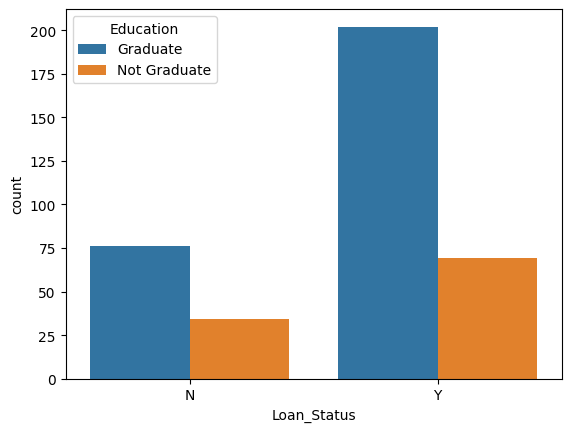

In [ ]:
sns.countplot(x="Loan_Status", hue="Education", data=loan_status_data);

### Variável Self_Employed

In [ ]:
# distribuição da Variável Autônomo
loan_status_data['Self_Employed'].value_counts()

No     325
Yes     35
Name: Self_Employed, dtype: int64

In [ ]:
# Verificando como a condição autônoma está relacionado com a variável alvo
pd.crosstab(loan_status_data['Loan_Status'], loan_status_data['Self_Employed'], margins=True)

Self_Employed,No,Yes,All
Loan_Status,,,
N,95,11,106
Y,230,24,254
All,325,35,360


<p>Quase 90.03% das pessoas da base de dados são pessaos não autônomas e entre elas 90.55% tiveram o empréstimo aceito, pelo fato de haver poucos registros para as pessoas autônomas então os 21 registros NaN será preenchido pela classe Yes.<p>

### Variável ApplicantIncome

Text(0.5, 1.0, 'boxplot do ApplicantIncome')

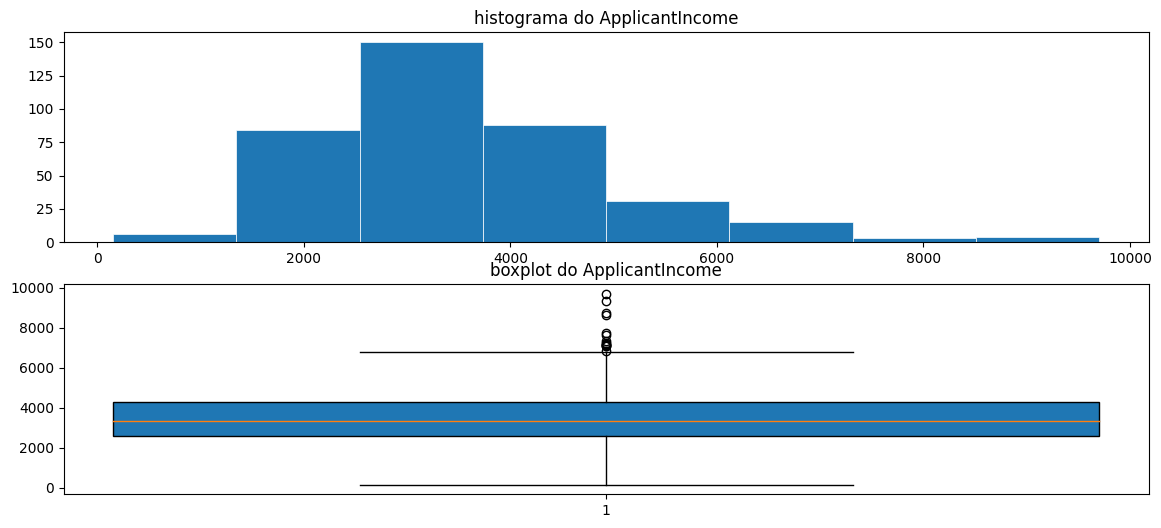

In [ ]:
# Distribuição da variável renda do candidato
## Inserir os gráficos numa única visualização
fig, axis = plt.subplots(2, figsize=(14, 6))

axis[0].hist(loan_status_data['ApplicantIncome'], bins=8, linewidth=0.5, edgecolor="white")
axis[0].set_title('histograma do ApplicantIncome')

axis[1].boxplot(loan_status_data['ApplicantIncome'], widths=1.5, patch_artist=True)
axis[1].set_title('boxplot do ApplicantIncome')

<p>Pelos gráficos podemos supor uma renda acima de 7k é considerado uma renda fora do comum.<p>

In [ ]:
# resumo estatístico da variável sem o outlier
loan_status_data['ApplicantIncome'].loc[loan_status_data['ApplicantIncome'] < 7000].describe(), loan_status_data['ApplicantIncome'].describe()

(count     368.000000
 mean     3428.923913
 std      1179.003075
 min       150.000000
 25%      2583.000000
 50%      3279.500000
 75%      4166.000000
 max      6822.000000
 Name: ApplicantIncome, dtype: float64,
 count     381.000000
 mean     3579.845144
 std      1419.813818
 min       150.000000
 25%      2600.000000
 50%      3333.000000
 75%      4288.000000
 max      9703.000000
 Name: ApplicantIncome, dtype: float64)

<p>Podemos ver que a média e desvio padrão dos dados com e sem outliers possui uma diferença significativa.<p>

### Variável CoapplicantIncome

Text(0.5, 1.0, 'boxplot do CoapplicantIncome')

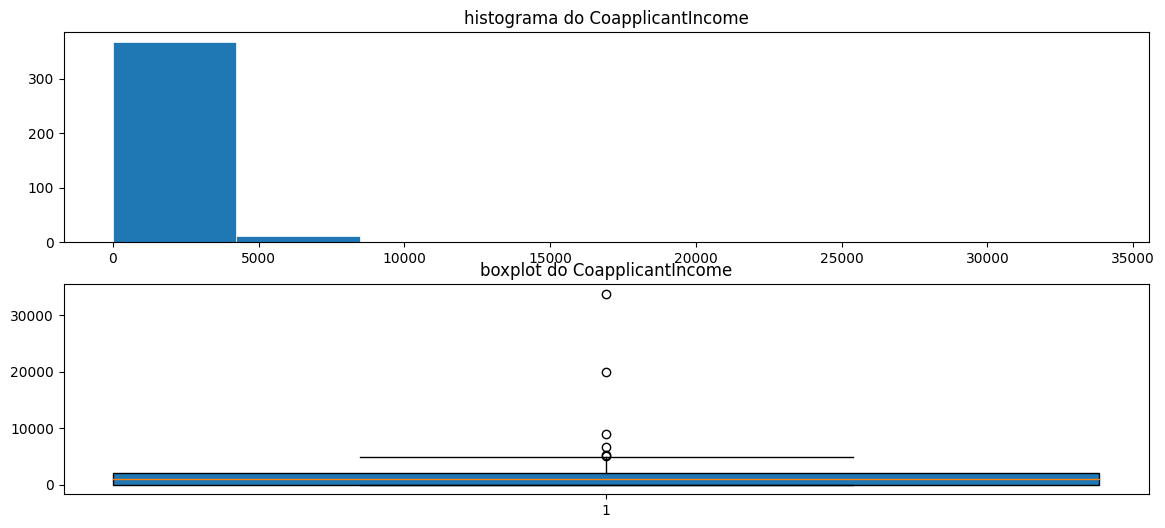

In [ ]:
# Distribuição da variável renda do corequerente
## Inserir os gráficos numa única visualização
fig, axis = plt.subplots(2, figsize=(14, 6))

axis[0].hist(loan_status_data['CoapplicantIncome'], bins=8, linewidth=0.5, edgecolor="white")
axis[0].set_title('histograma do CoapplicantIncome')

axis[1].boxplot(loan_status_data['CoapplicantIncome'], widths=1.5, patch_artist=True)
axis[1].set_title('boxplot do CoapplicantIncome')

In [ ]:
# resumo estatístico da variável sem o outlier
loan_status_data['CoapplicantIncome'].loc[loan_status_data['CoapplicantIncome'] < 8000].describe(), loan_status_data['CoapplicantIncome'].describe()

(count     378.000000
 mean     1121.229947
 std      1264.670693
 min         0.000000
 25%         0.000000
 50%       918.000000
 75%      1998.250000
 max      6666.000000
 Name: CoapplicantIncome, dtype: float64,
 count      381.000000
 mean      1277.275381
 std       2340.818114
 min          0.000000
 25%          0.000000
 50%        983.000000
 75%       2016.000000
 max      33837.000000
 Name: CoapplicantIncome, dtype: float64)

<p>Mesmo tendo poucos outliers ainda assim afeta bastante as medidas estaatísticas da variável, necessitando da possível remoção.<p>

### Variável LoanAmount

Text(0.5, 1.0, 'boxplot do LoanAmount')

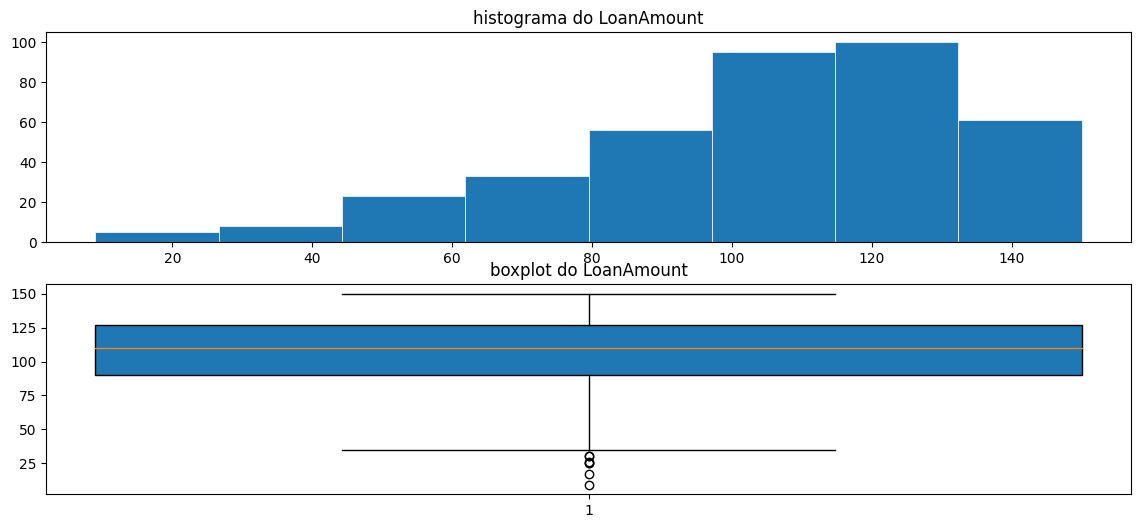

In [ ]:
# Distribuição da variável quantidade do empréstimo
## Inserir os gráficos numa única visualização
fig, axis = plt.subplots(2, figsize=(14, 6))

axis[0].hist(loan_status_data['LoanAmount'], bins=8, linewidth=0.5, edgecolor="white")
axis[0].set_title('histograma do LoanAmount')

axis[1].boxplot(loan_status_data['LoanAmount'], widths=1.5, patch_artist=True)
axis[1].set_title('boxplot do LoanAmount')

In [ ]:
# resumo estatístico da variável sem o outlier
loan_status_data['LoanAmount'].loc[loan_status_data['LoanAmount'] > 37.5].describe(), loan_status_data['LoanAmount'].describe()

(count    372.000000
 mean     106.900538
 std       25.820306
 min       40.000000
 25%       93.750000
 50%      111.000000
 75%      128.000000
 max      150.000000
 Name: LoanAmount, dtype: float64,
 count    381.000000
 mean     104.986877
 std       28.358464
 min        9.000000
 25%       90.000000
 50%      110.000000
 75%      127.000000
 max      150.000000
 Name: LoanAmount, dtype: float64)

<p>As medidas estatísticas não mudam tanto, podendo ser indício de que eles podem não afetar tanto na hora da previsão.<p>

### Variável Loan_Amount_Term

In [ ]:
# Distribuição da variável Loan_Amount_Term
loan_status_data['Loan_Amount_Term'].value_counts()

360.0    312
180.0     29
480.0     11
300.0      7
120.0      3
84.0       3
240.0      2
60.0       1
12.0       1
36.0       1
Name: Loan_Amount_Term, dtype: int64

In [ ]:
# Verificando como a Educação está relacionado com a variável alvo
pd.crosstab(loan_status_data['Loan_Status'], loan_status_data['Loan_Amount_Term'], margins=True)

Loan_Amount_Term,12.0,36.0,60.0,84.0,120.0,180.0,240.0,300.0,360.0,480.0,All
Loan_Status,,,,,,,,,,,
N,0,1,0,0,0,10,0,3,84,7,105
Y,1,0,1,3,3,19,2,4,228,4,265
All,1,1,1,3,3,29,2,7,312,11,370


### Variável Credit_History

In [ ]:
# Distribuição da variável Credit_History
loan_status_data['Credit_History'].value_counts()

1.0    294
0.0     57
Name: Credit_History, dtype: int64

<p>Como não foi especificado o que representa os valores 1.0 ou 0.0 e tem 30 registros nulos então essa variável será removida do dataset.<p>

### Variável Property_Area

In [ ]:
# distribuição da Variável Property_Area
loan_status_data['Property_Area'].value_counts()

Semiurban    149
Urban        126
Rural        106
Name: Property_Area, dtype: int64

In [ ]:
# Verificando como a Property_Area está relacionado com a variável alvo
pd.crosstab(loan_status_data['Loan_Status'], loan_status_data['Property_Area'], margins=True)

Property_Area,Rural,Semiurban,Urban,All
Loan_Status,,,,
N,41,30,39,110
Y,65,119,87,271
All,106,149,126,381


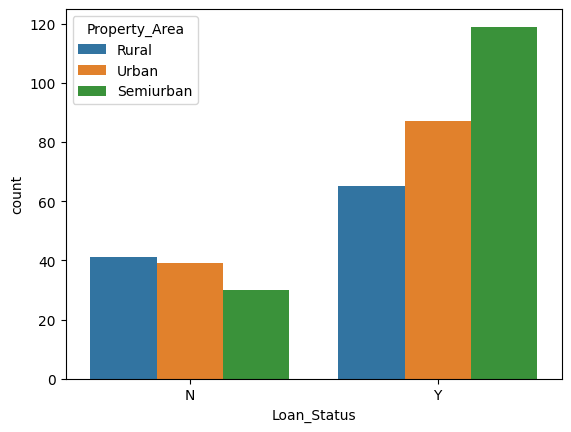

In [ ]:
sns.countplot(x="Loan_Status", hue="Property_Area", data=loan_status_data);

<p>Para essa variável temos que a maioria das pessoas semiurbanas tiveram o empréstimo aceito, há quase um equilíbrio na classe Rural para o empréstimo aceito/não-aceito.<p>

### Variável Loan_Status (Variável alvo)

In [ ]:
# distribuição da Variável Loan_Status
loan_status_data['Loan_Status'].value_counts()

Y    271
N    110
Name: Loan_Status, dtype: int64

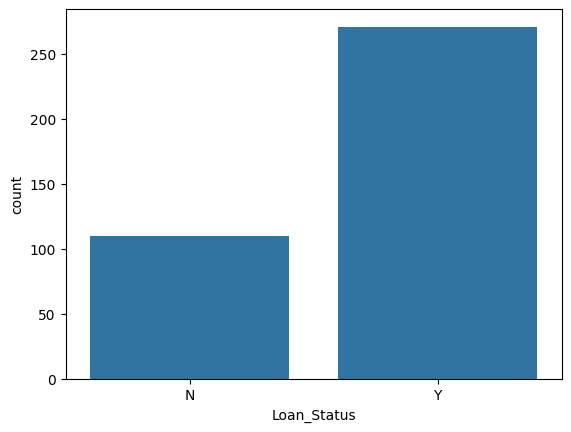

In [ ]:
sns.countplot(x="Loan_Status", data=loan_status_data);

<p>A variável alvo não está balanceada, ou seja tem mais registros Yes do que No, podendo influenciar o modelo a aprender a dar crédito do que não dar, mas isso depende muito da proposta do banco, dar o empréstimo a uma pessoa que não paga é mais prejudicial a não dar empréstimo a uma pessoa que paga? Nesse caso é mais prejudicial a primeira opção, ou seja, mesmo que o objetivo seja usar ML paara criar um modelo que possa classificar a dar ou não empréstimo, seráa focado em dimimir o erro de Yes para pessoas que não pagam.<p>

<p>Suposição rápida para as variáveis categóricas: Se é homem, é casado, não tem dependente, são graduadas, não autônomas, tem propriedade semiurbano ou urbano, termos do empréstimo em 360 então conceda o empréstimo<p>
<p>Remover a coluna Credit_History<p>

## Deletando uma coluna e inserindo valores no lugar do NaN

In [ ]:
# Deletando a coluna Credit_History
loan_status_data.drop('Credit_History', axis=1, inplace=True)

In [ ]:
# Substituindo os valores nulos
loan_status_data['Gender'].fillna('Female', inplace=True)
loan_status_data['Loan_Amount_Term'].fillna(360.0, inplace=True)
loan_status_data['Dependents'].fillna('0', inplace=True)
loan_status_data['Self_Employed'].fillna('Yes', inplace=True)

In [ ]:
# Removendo os outliers da coluna
loan_status_data = loan_status_data[ loan_status_data['CoapplicantIncome'] < 8000]

# Removendo a coluna ID
loan_status_data.drop('Loan_ID', axis=1, inplace=True)

In [ ]:
# Quantidade de registros NaN
loan_status_data.isnull().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Property_Area        0
Loan_Status          0
dtype: int64

## Análise multivariada das características numéricas

In [ ]:
# Resumo estatístico
loan_status_data.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term
count,378.000000,378.000000,378.000000,378.000000
mean,3591.132275,1121.229947,104.947090,341.269841
std,1419.543455,1264.670693,28.412598,67.874093
min,150.000000,0.000000,9.000000,12.000000
25%,2600.000000,0.000000,90.000000,360.000000
50%,3336.500000,918.000000,110.000000,360.000000
75%,4297.000000,1998.250000,127.000000,360.000000
max,9703.000000,6666.000000,150.000000,480.000000


In [ ]:
# Correlação dos dados
loan_status_data.corr()

<ipython-input-22-192d9d5ee597>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  loan_status_data.corr()


,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term
ApplicantIncome,1.000000,-0.332896,0.273556,-0.103966
CoapplicantIncome,-0.332896,1.000000,0.234415,-0.029501
LoanAmount,0.273556,0.234415,1.000000,0.121707
Loan_Amount_Term,-0.103966,-0.029501,0.121707,1.000000


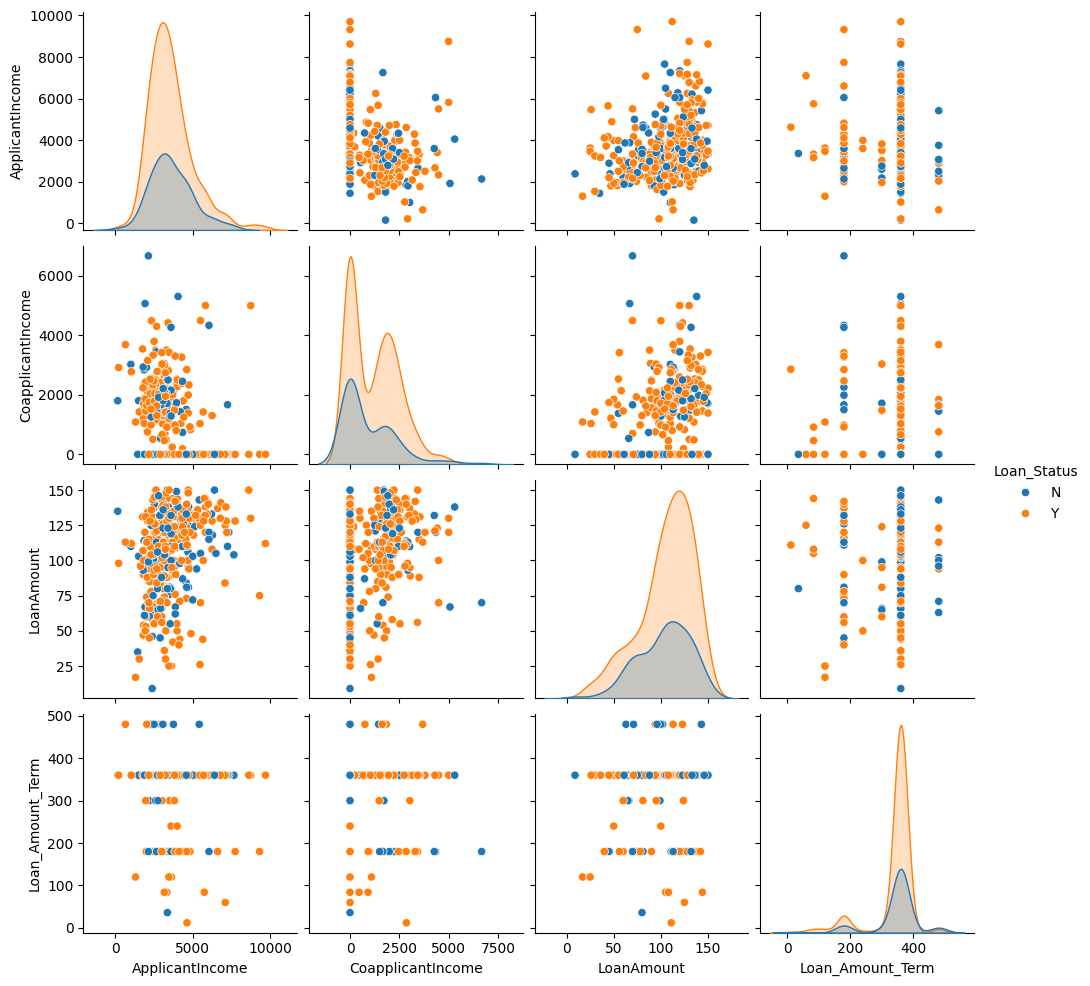

In [ ]:
# Matrix de dispersão das variáveis numéricas em relação a variável alvo
sns.pairplot(loan_status_data, hue="Loan_Status")
plt.savefig('correlação_loan_status')

<p>Anteriormente vimos que a variável ApplicantIncome possuia outlers, mas não removemos de imediato como foi na CoapplicantIncome porque talvez não possa influenciar tanto assim, mas vamos ver com o uso desse mesmo gráfico como que fica sem esses outliers.<p>

In [ ]:
loan_status_data[ loan_status_data['ApplicantIncome'] < 7000 ].corr()

<ipython-input-28-aaefc7ae5f8a>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  loan_status_data[ loan_status_data['ApplicantIncome'] < 7000 ].corr()


,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term
ApplicantIncome,1.000000,-0.360187,0.284867,-0.067492
CoapplicantIncome,-0.360187,1.000000,0.246950,-0.051316
LoanAmount,0.284867,0.246950,1.000000,0.131102
Loan_Amount_Term,-0.067492,-0.051316,0.131102,1.000000


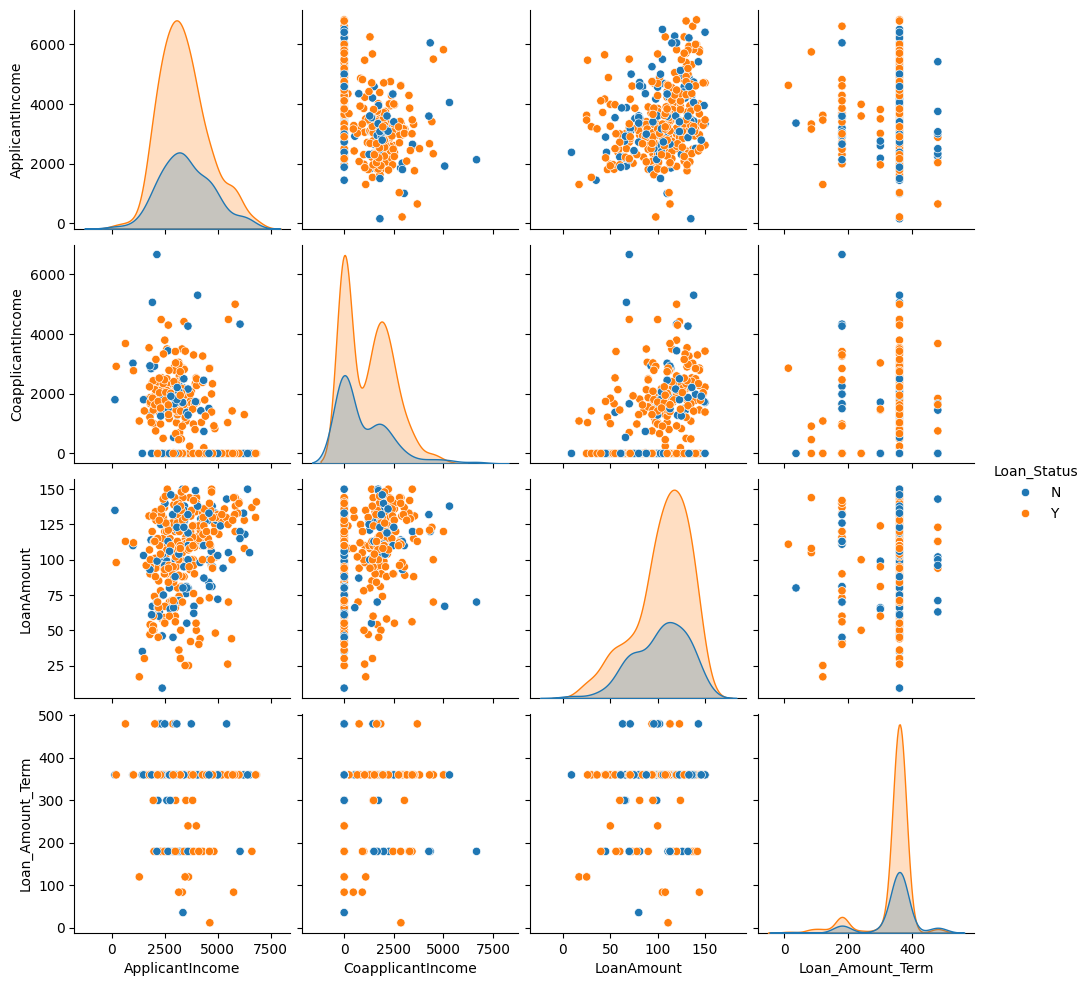

In [ ]:
# Matrix de dispersão das variáveis numéricas em relação a variável alvo
sns.pairplot(loan_status_data[ loan_status_data['ApplicantIncome'] < 7000 ], hue="Loan_Status")
#plt.savefig('correlação_loan_status')

<p>Vimos que não mudou tanto assim. Concluimos que LoanAmount possui uma correlação fraca com ApplicationIncome e CoaplicationIncome, Loan_Amount Não possui correlação com as outras variáveis e ApplicationIncome e CoaplicationIncome possuem uma correlação fraca negativa, ou seja, fraca proporção inversa.<p>

# Pré-processamento dos Dados

<p>Neste tópico os dados serão transformados antes de serem passados para o modelo. Porém, há modelos que podem trabalhar bem com os dados do jeito que estão como é o caso da árvore de decisão.<p>

In [ ]:
loan_status_data.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Property_Area,Loan_Status
0,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,Rural,N
1,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,Urban,Y
2,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,Urban,Y
3,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,Urban,Y
4,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,Urban,Y


<p>Vamos usar o OrdinalEncoder do pacote preprocessing do Scikit Learning.<p>

In [ ]:
# Separando os dados em previsores e resposta
loan_status_previsor_prep = loan_status_data.drop('Loan_Status', axis=1)
loan_status_resposta_prep = loan_status_data['Loan_Status']

In [ ]:
# Definindo o objeto encoder
encoder = OrdinalEncoder()

# transformação dos dados
gender_enconder = encoder.fit_transform(np.array(loan_status_previsor_prep['Gender']).reshape(-1,1)) # 1 - Male ; 0 - Female
married_enconder = encoder.fit_transform(np.array(loan_status_previsor_prep['Married']).reshape(-1,1)) # 1- Yes ; 0 - No
dependents_enconder = encoder.fit_transform(np.array(loan_status_previsor_prep['Dependents']).reshape(-1,1)) # Normal como está no dataset
education_enconder = encoder.fit_transform(np.array(loan_status_previsor_prep['Education']).reshape(-1,1)) # 0 - Graduate ; 1 - Not Graduate
self_employed_enconder = encoder.fit_transform(np.array(loan_status_previsor_prep['Self_Employed']).reshape(-1,1)) # 0 - No ; 1 - Yes
property_area_enconder = encoder.fit_transform(np.array(loan_status_previsor_prep['Property_Area']).reshape(-1,1)) # 0 - Rural ; 2 - Urban ; 1 - Semiurban
loan_status_enconder = encoder.fit_transform(np.array(loan_status_resposta_prep).reshape(-1,1)) # 0 - N ; 1 - Y

In [ ]:
# Definindo o objeto padronizador
scaler = StandardScaler()

# transformação dos dados
applicantincome_scaled = scaler.fit_transform(np.array(loan_status_previsor_prep['ApplicantIncome']).reshape(-1,1))
coapplicantincome_scaled = scaler.fit_transform(np.array(loan_status_previsor_prep['CoapplicantIncome']).reshape(-1,1))
loanamount_scaled = scaler.fit_transform(np.array(loan_status_previsor_prep['LoanAmount']).reshape(-1,1))
loan_amount_term_scaled = scaler.fit_transform(np.array(loan_status_previsor_prep['Loan_Amount_Term']).reshape(-1,1))

In [ ]:
# Atualizando o dataset com os novos dados
loan_status_previsor_prep['Gender'] = gender_enconder
loan_status_previsor_prep['Married'] = married_enconder
loan_status_previsor_prep['Dependents'] = dependents_enconder
loan_status_previsor_prep['Education'] = education_enconder
loan_status_previsor_prep['Self_Employed'] = self_employed_enconder
loan_status_previsor_prep['ApplicantIncome'] = applicantincome_scaled
loan_status_previsor_prep['CoapplicantIncome'] = coapplicantincome_scaled
loan_status_previsor_prep['LoanAmount'] = loanamount_scaled
loan_status_previsor_prep['Loan_Amount_Term'] = loan_amount_term_scaled
loan_status_previsor_prep['Property_Area'] = property_area_enconder
loan_status_resposta_prep = loan_status_enconder

In [ ]:
# Transformando em um np.array
loan_status_previsor = np.array(loan_status_previsor_prep)
loan_status_resposta = np.array(loan_status_resposta_prep)

loan_status_previsor[0], loan_status_resposta[0]

(array([1.        , 1.        , 1.        , 0.        , 0.        ,
        0.69964912, 0.30623203, 0.81243764, 0.27632021, 0.        ]),
 array([0.]))

In [ ]:
# Mudando o shape da variável alvo para uma matrix
loan_status_resposta = loan_status_resposta.reshape(-1,1)
loan_status_resposta[0:4]

array([[0.],
       [1.],
       [1.],
       [1.]])

In [ ]:
# Separado os dados em treino e teste
loan_train_x, loan_test_x, loan_train_y, loan_test_y = train_test_split(loan_status_previsor, loan_status_resposta,
                                                                        test_size=0.2, random_state=1)

In [ ]:
# Verificando o tamanho do dataset
len(loan_train_x), len(loan_test_x), len(loan_train_y), len(loan_test_y)

(302, 76, 302, 76)

In [ ]:
loan_train_x[0], loan_train_y[0]

(array([ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.79840309, -0.88775363, -0.8439506 ,  0.27632021,  1.        ]),
 array([0.]))

# Modelando os modelos

## Árvore de Decisão

<p>Utilizando o grid search para achar os mehores hiperparâmetros.<p>

In [ ]:
# Definir os hiperparâmetros a serem ajustados
param_grid_dtc = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'max_depth': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    'max_leaf_nodes': [5, 7, 9, 11, 13, 15, 17, 19, 21]
}

# Crio o modelo
loan_dtc_gs = DecisionTreeClassifier(random_state=2)

# Criar o objeto GridSearchCV
grid_search_dtc = GridSearchCV(loan_dtc_gs, param_grid_dtc, cv=10)

# Executar o Grid Search
grid_search_dtc.fit(loan_train_x, loan_train_y)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=2),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [5, 6, 7, 8, 9, 9, 10, 11, 12, 13, 14,
                                       15],
                         'max_leaf_nodes': [5, 7, 9, 11, 13, 15, 17, 19, 21],
                         'splitter': ['best', 'random']})

In [ ]:
# Dicionário dos melhores parâmetros
melhor_par = grid_search_dtc.best_params_

# Imprimir os melhores parâmetros encontrados
print(f"Melhores hiperparâmetros encontrados: {melhor_par}")
print(f"Score do modelo: {grid_search_dtc.best_score_}")

Melhores hiperparâmetros encontrados: {'criterion': 'entropy', 'max_depth': 5, 'max_leaf_nodes': 9, 'splitter': 'random'}
Score do modelo: 0.7153763440860216


<p>Testando manualmente o modelo com os melhores hiperparâmetros.<p>

In [ ]:
# 0.76 -> criterion='gini', splitter='best', max_depth=5, max_leaf_nodes=10

# Crio o modelo
loan_dtc = DecisionTreeClassifier(criterion=melhor_par['criterion'], splitter=melhor_par['splitter'], max_depth=melhor_par['max_depth']
                                  , max_leaf_nodes=melhor_par['max_leaf_nodes'], random_state=2)

# Treino o modelo
loan_dtc = loan_dtc.fit(loan_train_x, loan_train_y)

In [ ]:
# Usando o modelo
loan_dtc_predict = loan_dtc.predict(loan_test_x)

In [ ]:
# Verificando as respostas
loan_dtc_predict

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1.])

## Máquina de Vetores de Suporte

<p>Utilizando o grid search para achar os mehores hiperparâmetros.<p>

In [ ]:
# Definir os hiperparâmetros a serem ajustados
param_grid_svm = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [3, 4, 5, 6],
    'gamma': ['auto', 'scale'],
    'coef0': [0.0, 0.1, 0.001, 1, 0.5, 1.5],
}

# Crio o modelo
loan_svm_gs = SVC(random_state=2)

# Criar o objeto GridSearchCV
grid_search_svm = GridSearchCV(loan_svm_gs, param_grid_svm, cv=10)

# Executar o Grid Search
grid_search_svm.fit(loan_train_x, loan_train_y)

In [ ]:
# Dicionário dos melhores parâmetros
melhor_par_svm = grid_search_svm.best_params_

# Imprimir os melhores parâmetros encontrados
print(f"Melhores hiperparâmetros encontrados: {melhor_par_svm}")
print(f"Score do modelo: {grid_search_svm.best_score_}")

Melhores hiperparâmetros encontrados: {'C': 1, 'coef0': 0.0, 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf'}
Score do modelo: 0.7251612903225806


<p>Testando manualmente o modelo com os melhores hiperparâmetros.<p>

In [ ]:
# Cria o modelo
loan_svm = SVC(kernel=melhor_par_svm['kernel'], degree=melhor_par_svm['degree'], C=melhor_par_svm['C'],
               gamma=melhor_par_svm['gamma'], coef0=melhor_par_svm['coef0'], random_state=2)

# Treina o modelo
loan_svm = loan_svm.fit(loan_train_x, loan_train_y)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# Faz a previsão
loan_svm_predict = loan_svm.predict(loan_test_x)

In [ ]:
loan_svm_predict

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1.])

## Redes Neurais Artificiais

<p>Utilizando o grid search para achar os mehores hiperparâmetros.<p>

In [ ]:
# Definir os hiperparâmetros a serem ajustados
param_grid_nnc = {
    "hidden_layer_sizes": [(10,), (20,), (30,), (40,), (50,)],
    "activation" :['identity', 'logistic', 'tanh', 'relu'],
    "solver": ['lbfgs', 'sgd', 'adam'],
    "learning_rate" :['constant', 'invscaling', 'adaptive'],
    "max_iter": [10, 20, 30, 40, 50, 100]
}

# Crio o modelo
loan_nnc_gs = MLPClassifier(random_state=2)

# Criar o objeto GridSearchCV
grid_search_nnc = GridSearchCV(loan_nnc_gs, param_grid_nnc, cv=10)

# Executar o Grid Search
grid_search_nnc.fit(loan_train_x, loan_train_y)

A saída de streaming foi truncada nas últimas 5000 linhas.
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape 

GridSearchCV(cv=10, estimator=MLPClassifier(random_state=2),
             param_grid={'activation': ['identity', 'logistic', 'tanh', 'relu'],
                         'hidden_layer_sizes': [(10,), (20,), (30,), (40,),
                                                (50,)],
                         'learning_rate': ['constant', 'invscaling',
                                           'adaptive'],
                         'max_iter': [10, 20, 30, 40, 50, 100],
                         'solver': ['lbfgs', 'sgd', 'adam']})

In [ ]:
# Dicionário dos melhores parâmetros
melhor_par_nnc = grid_search_nnc.best_params_

# Imprimir os melhores parâmetros encontrados
print(f"Melhores hiperparâmetros encontrados: {melhor_par_nnc}")
print(f"Score do modelo: {grid_search_nnc.best_score_}")

Melhores hiperparâmetros encontrados: {'activation': 'tanh', 'hidden_layer_sizes': (40,), 'learning_rate': 'constant', 'max_iter': 40, 'solver': 'sgd'}
Score do modelo: 0.7119354838709677


<p>Testando manualmente o modelo com os melhores hiperparâmetros.<p>

In [ ]:
# Cria o modelo
loan_nnc = MLPClassifier(hidden_layer_sizes=melhor_par_nnc['hidden_layer_sizes'], activation=melhor_par_nnc['activation'],
               solver=melhor_par_nnc['solver'], learning_rate=melhor_par_nnc['learning_rate'],
               max_iter=melhor_par_nnc['max_iter'], random_state=2)

# Treina o modelo
loan_nnc = loan_nnc.fit(loan_train_x, loan_train_y)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
# Faz a previsão
loan_nnc_predict = loan_nnc.predict(loan_test_x)

In [ ]:
loan_nnc_predict

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1.])

# Avaliação

## Árvore de Decisão

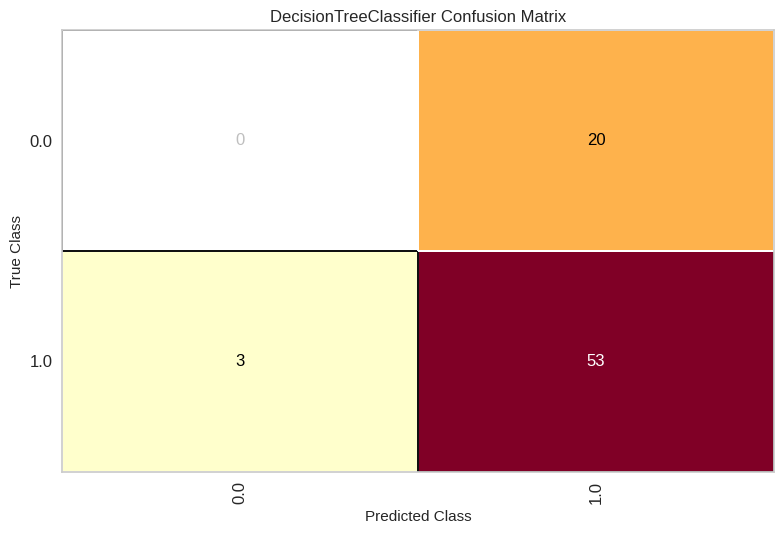

Axes(0.0878472,0.127778;0.889653x0.802525)


In [ ]:
# Construção da matriz de confusão
loan_cm = ConfusionMatrix(
    loan_dtc
)

# Treino
loan_cm.fit(loan_train_x, loan_train_y)

# Prevejo as classes
loan_cm.score(loan_test_x, loan_test_y)

# Visualizo a matriz de confusão
print(loan_cm.show())

In [ ]:
# Verificando os resultados
print(classification_report(loan_test_y, loan_dtc_predict))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        20
         1.0       0.73      0.95      0.82        56

    accuracy                           0.70        76
   macro avg       0.36      0.47      0.41        76
weighted avg       0.53      0.70      0.61        76



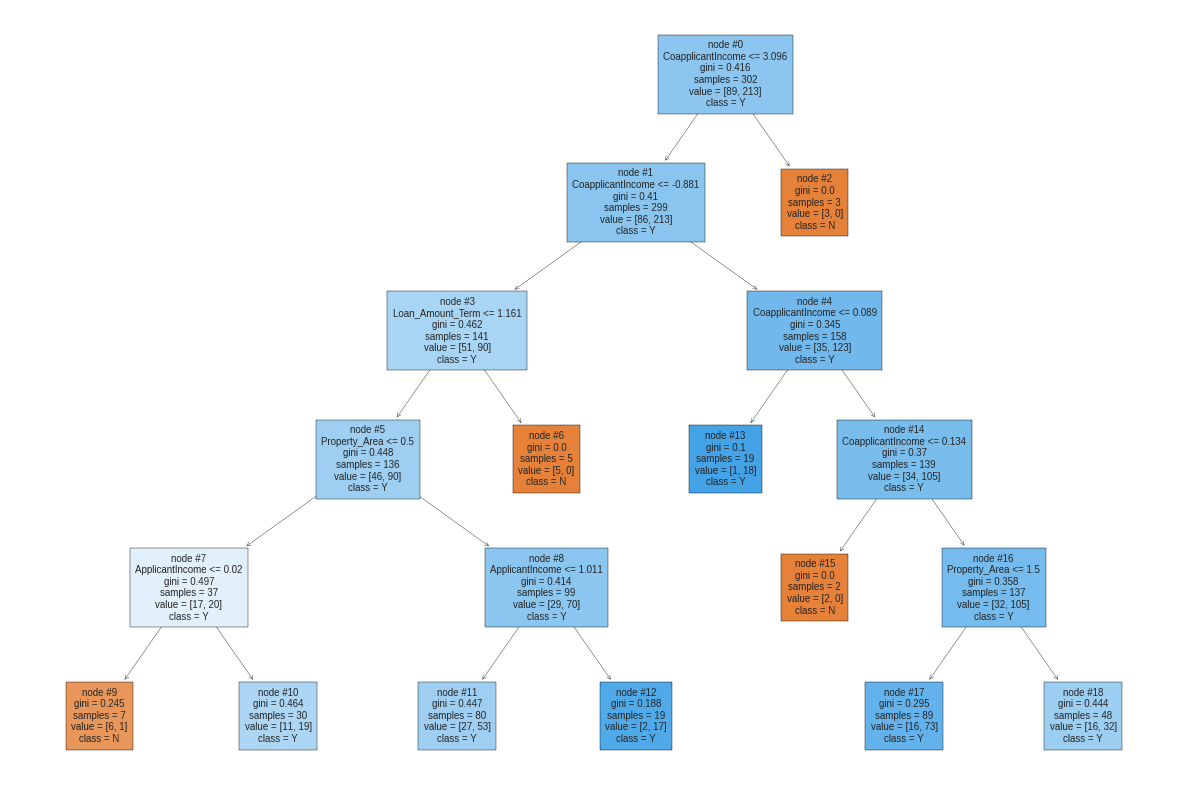

In [ ]:
# Previsores e Classe para a geração da árvore
previsores = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Property_Area', 'Loan_Status']
classes = ['N', 'Y']

# Visualização da árvore de decisão
figura, eixos = plt.subplots(nrows=1, ncols=1, figsize=(15,10))
plot_tree(loan_dtc, feature_names=previsores, class_names=classes, fontsize=7, filled=True, max_depth=5, node_ids=True);
plt.savefig('dtc_apple')

<p>Usando a validação cruzada para avaliar o desempenho do modelo de acordo com os melhores hiperparâmetros encontrados.<p>

In [ ]:
# Criar o modelo de árvore de decisão
loan_dtc_vc = DecisionTreeClassifier(criterion=melhor_par['criterion'], splitter=melhor_par['splitter'], max_depth=melhor_par['max_depth'],
                                     max_leaf_nodes=melhor_par['max_leaf_nodes'], random_state=2)

# Realizar validação cruzada com 10 folds
scores_dtc = cross_val_score(loan_dtc_vc, loan_train_x, loan_train_y, cv=10)

# Imprimir os resultados da validação cruzada
print(f"Scores da validação cruzada: {scores_dtc}")
print("Acurácia média: %0.3f (+/- %0.3f)" % (scores_dtc.mean(), scores_dtc.std() * 2))

Scores da validação cruzada: [0.64516129 0.74193548 0.7        0.73333333 0.76666667 0.76666667
 0.7        0.66666667 0.7        0.73333333]
Acurácia média: 0.715 (+/- 0.076)


## Máquina de Vetores de Suporte

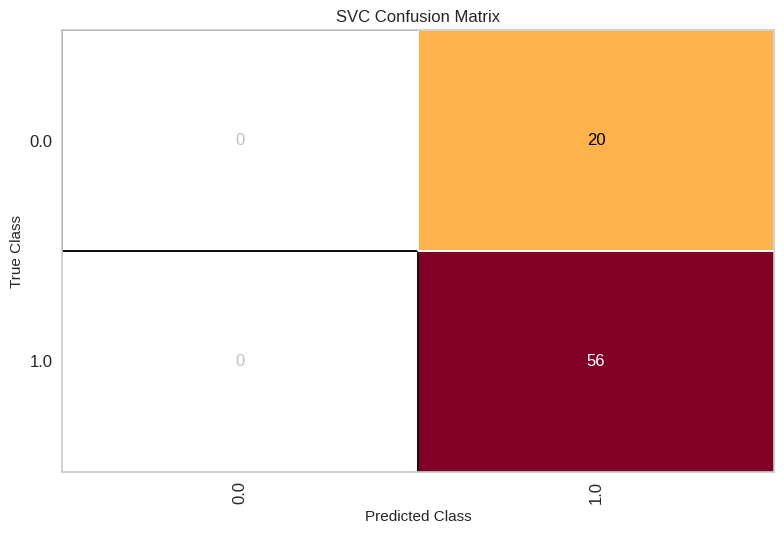

Axes(0.0878472,0.127778;0.889653x0.802525)


In [ ]:
# Construção da matriz de confusão
loan_cm_svm = ConfusionMatrix(
    loan_svm
)

# Treino
loan_cm_svm.fit(loan_train_x, loan_train_y)

# Prevejo as classes
loan_cm_svm.score(loan_test_x, loan_test_y)

# Visualizo a matriz de confusão
print(loan_cm_svm.show())

In [ ]:
# Verificando os resultados
print(classification_report(loan_test_y, loan_svm_predict))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        20
         1.0       0.74      1.00      0.85        56

    accuracy                           0.74        76
   macro avg       0.37      0.50      0.42        76
weighted avg       0.54      0.74      0.63        76



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<p>Usando a validação cruzada para avaliar o desempenho do modelo de acordo com os melhores hiperparâmetros encontrados.<p>

In [ ]:
# Cria o modelo
loan_svm_vc = SVC(kernel=melhor_par_svm['kernel'], degree=melhor_par_svm['degree'], C=melhor_par_svm['C'],
               gamma=melhor_par_svm['gamma'], coef0=melhor_par_svm['coef0'], random_state=2)

# Realizar validação cruzada com 10 folds
scores_svm = cross_val_score(loan_svm_vc, loan_train_x, loan_train_y, cv=10)

# Imprimir os resultados da validação cruzada
print(f"Scores da validação cruzada: {scores_svm}")
print("Acurácia média: %0.3f (+/- %0.3f)" % (scores_svm.mean(), scores_svm.std() * 2))

Scores da validação cruzada: [0.74193548 0.70967742 0.73333333 0.73333333 0.73333333 0.73333333
 0.73333333 0.7        0.7        0.73333333]
Acurácia média: 0.725 (+/- 0.030)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

## Rede Neural Artificial

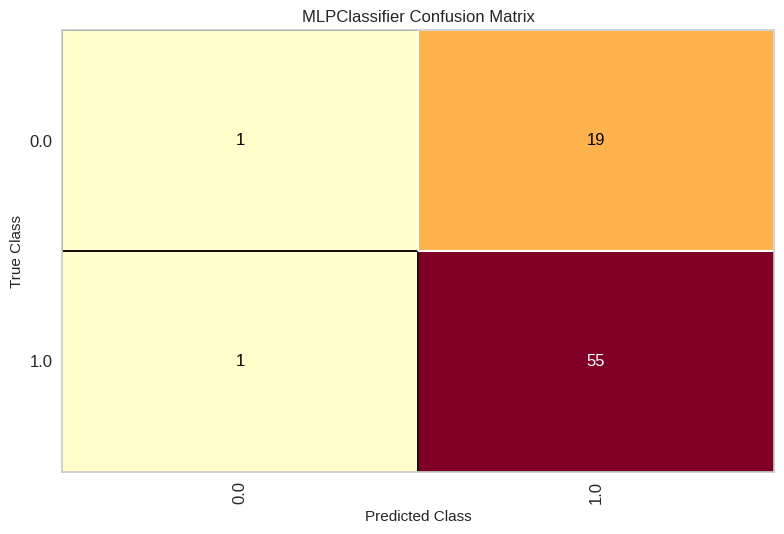

Axes(0.0878472,0.127778;0.889653x0.802525)


In [ ]:
# Construção da matriz de confusão
loan_cm_nnc = ConfusionMatrix(
    loan_nnc
)

# Treino
loan_cm_nnc.fit(loan_train_x, loan_train_y)

# Prevejo as classes
loan_cm_nnc.score(loan_test_x, loan_test_y)

# Visualizo a matriz de confusão
print(loan_cm_nnc.show())

In [ ]:
# Verificando os resultados
print(classification_report(loan_test_y, loan_nnc_predict))

              precision    recall  f1-score   support

         0.0       0.50      0.05      0.09        20
         1.0       0.74      0.98      0.85        56

    accuracy                           0.74        76
   macro avg       0.62      0.52      0.47        76
weighted avg       0.68      0.74      0.65        76



<p>Usando a validação cruzada para avaliar o desempenho do modelo de acordo com os melhores hiperparâmetros encontrados.<p>

In [ ]:
# Cria o modelo
loan_nnc_vc = MLPClassifier(hidden_layer_sizes=melhor_par_nnc['hidden_layer_sizes'], activation=melhor_par_nnc['activation'],
               solver=melhor_par_nnc['solver'], learning_rate=melhor_par_nnc['learning_rate'],
               max_iter=melhor_par_nnc['max_iter'], random_state=2)

# Realizar validação cruzada com 10 folds
scores_nnc = cross_val_score(loan_nnc_vc, loan_train_x, loan_train_y, cv=10)

# Imprimir os resultados da validação cruzada
print(f"Scores da validação cruzada: {scores_nnc}")
print("Acurácia média: %0.3f (+/- %0.3f)" % (scores_nnc.mean(), scores_nnc.std() * 2))

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converge

Scores da validação cruzada: [0.70967742 0.70967742 0.73333333 0.7        0.7        0.73333333
 0.7        0.7        0.7        0.73333333]
Acurácia média: 0.712 (+/- 0.029)


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = col


# Conclusões

<p>Tabela mostrando os accuracy dos 3 modelos usando Grid Search e a média dos accuracy da validação cruzada (VC).<p>
<table>
<thead>
<tr>
<th>Modelo</th>
<th>Grid Search
<th>VC (média)</th>
<th>VC (Desvio Padrão)</th>
</tr>
</thead>
<tbody>

<tr>
<td>Árvore de Decisão</td>
<td>0,70</td>
<td>0,715</td>
<td>+/- 0.076</td>
</tr>

<tr>
<td>Máquina de Vetor de Suporte (SVM)</td>
<td>0,74</td>
<td>0,725</td>
<td>+/- 0.030</td>
</tr>

<tr>
<td>Rede Neural Artificial</td>
<td>0.74</td>
<td>0,712</td>
<td>+/- 0.029</td>
</tr>

</tbody>
</table>

<p>Observando os resultados dos 3 modelos, para o grid search que busca os melhores hiperpâmetros a redes neural e SVM foram bons em comparação à árvore. Porém, utilizando a validação cruzada e dividindo o dataset em 10 folds (normalmente usa-se o valor k=10 para o particionamento na validação cruzzada) percebemos que a SVM possui o maior accuracy médio dos 3.<p>
<p>Infelizmente o accuracy não foi maior que os 80%, podendo ser um indício que o tratamentos dos dados escolhido não foi adequado e, pode ser, o tratamento dos dados NaN talvez não seja o correto.<p>

<p>O objetivo do projeto é criar um modelo que possa dizer se é para aceitar ou não a realização do empréstimo para um tal cliente, possa ser mais interssante para o banco evitar que o modelo dar empréstimo para um cliente que não possa pagar, nesse caso foi focado em reduzir as chances para que isso ocorresse. Pelos resultados vimos que a Árvore e SVM deram Y (sim para o empréstimo) para 20 pessoas que tem o rótulo N (não, para não dar o empréstimo) e a Rede Neural deu apenas 19. Com isso podemos dizer que a Rede Neural foi melhor para esse problemas, mesmo que a accuracy médio seja menor em relação com as duas.<p>
<p>Pela análise dos dados vimos que existem mais registros de pessoas que tiveram empréstimo aceito (71,129%) em comparação a pessoas que não tiveram, com essa proporção o dataset é desbalanceado, por isso que é natural o modelo aprender mais sobre a classe Y que a classe N.<p>

<p>Um objetivo de melhoria seria usar outros tipos de pré-processamento como o One Hot Encoder e revisar a forma como foi tratado os dados NaN. Além disso, o balanceamento dos dados pode ser interessante para que seja previsto corretamente a classe N.<p>